In [1]:
import pandas as pd
import numpy as np  
import os 
from pathlib import Path
import pickle
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns

In [2]:
os.chdir((Path.home()/"wdpath.txt").read_text().strip())

In [3]:
with open("processed-data/002-dat-dict.pkl",'rb') as f:
    dat_dict = pickle.load(f)

### Fix colData index

In [4]:
dat_dict['colData'].index = dat_dict['colData'].SAMPID

### Remove sparse genes 

In [5]:
na_sum = dat_dict['logcounts'].isna().sum(axis=1).values
na_prop = na_sum / (dat_dict['logcounts'].shape[1])
print(na_prop)
# ^^ not necessary

[0. 0. 0. ... 0. 0. 0.]


### Calculate reduced dimensions

In [6]:
# fit PCA to capture 95% of variance (change n_components as needed)
print("Running PCA…")
pca = PCA(n_components=50, svd_solver='auto', random_state=0)
scores = pca.fit_transform(np.transpose(dat_dict['logcounts']))
scores = np.transpose(scores)
print("PCA finished")

Running PCA…
PCA finished


In [7]:
print(scores.shape)
print(pca.explained_variance_ratio_.sum())

(50, 12460)
0.771134911004435


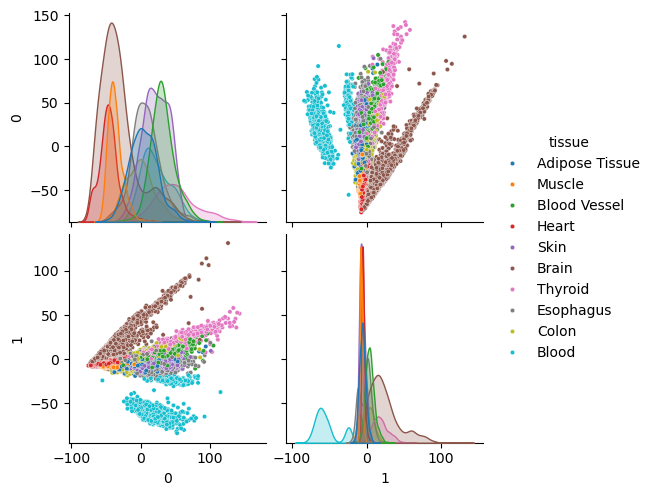

In [8]:
df = pd.DataFrame(np.transpose(scores)).iloc[:, :2].copy()
df["tissue"] = dat_dict["colData"]["SMTS"].values
sns.pairplot(df,
             hue="tissue",
             plot_kws={'s': 10})
plt.show()
plt.close()

In [9]:
# add to dat_dict
dat_dict['rDims'] = {}
dat_dict['rDims']['PCA']= {"scores": scores.T, "attributes": pca}

#### Other dimension reduction technique

NMF

In [10]:
# NMF needs the data to be non-negative
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_non_negative = scaler.fit_transform(dat_dict['logcounts'].T)

In [11]:
X_non_negative.shape

(12460, 5000)

In [16]:
from sklearn.decomposition import NMF

nmf_path = Path("processed-data/nmf-redux.pkl")
if not nmf_path.exists():
    np.random.seed(1293)
    nmf = NMF(n_components=50, max_iter=1000)
    nmf.fit(X_non_negative)
    X_nmf_reduced = nmf.transform(X_non_negative)
    with open(nmf_path, "wb") as f:
        pickle.dump([X_nmf_reduced,nmf], f)
else:
    with open(nmf_path, "rb") as f:
        X_nmf_reduced , nmf = pickle.load(f)

In [18]:
plot_d = (
    pd.DataFrame(X_nmf_reduced[:, :3])
    .assign(tissue = dat_dict['colData'].SMTS.values)
)

plot_d.head

<bound method NDFrame.head of               0         1         2          tissue
0      0.078728  0.002625  0.000000  Adipose Tissue
1      0.000000  0.000000  0.000000          Muscle
2      0.000000  0.000000  0.000000    Blood Vessel
3      0.055578  0.003413  0.000000    Blood Vessel
4      0.018269  0.000000  0.000000           Heart
...         ...       ...       ...             ...
12455  0.013669  0.000000  0.000615         Thyroid
12456  0.017873  0.000000  0.000000       Esophagus
12457  0.034450  0.004322  0.000000    Blood Vessel
12458  0.016644  0.000000  0.000000          Muscle
12459  0.072827  0.000000  0.000000  Adipose Tissue

[12460 rows x 4 columns]>

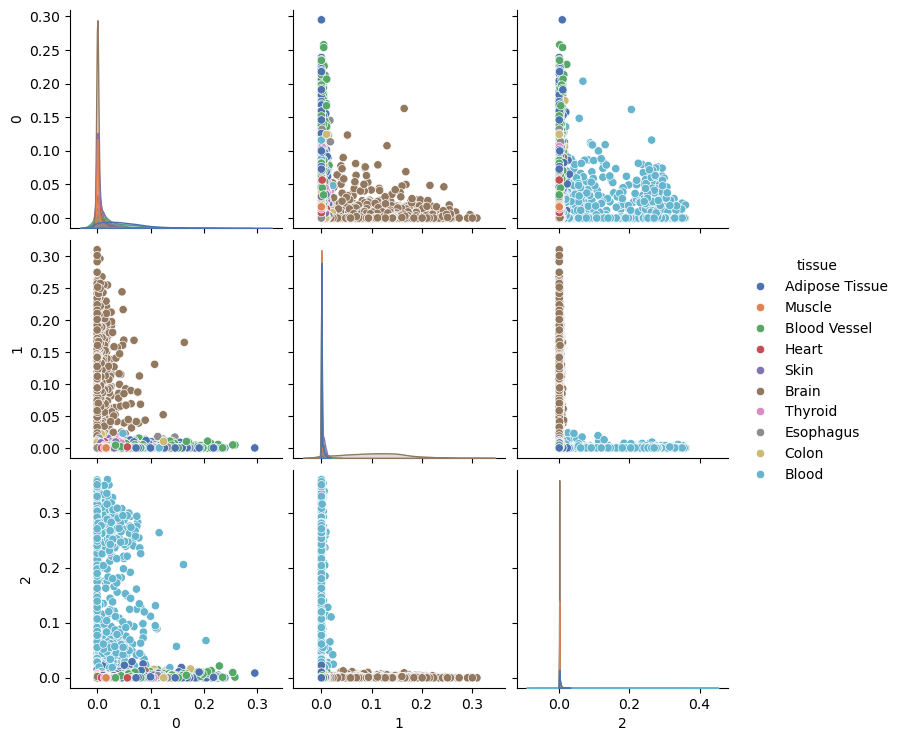

In [19]:
sns.pairplot(
    plot_d,
    hue='tissue',
    palette="deep",
    # diag_kind="hist",
    # corner = True
)
plt.show()

In [20]:

# add to dat_dict
dat_dict['rDims']['NMF'] = {"scores": X_nmf_reduced, "attributes": nmf}

### Save

In [21]:
print("Saving...")
with(open("processed-data/003-dat-dict.pkl", 'wb') as f ):
    pickle.dump(dat_dict, f)
print("Done")

Saving...
Done
